In [1]:
import copy
import sys
sys.path.append('../utils/')
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

(0, 100)

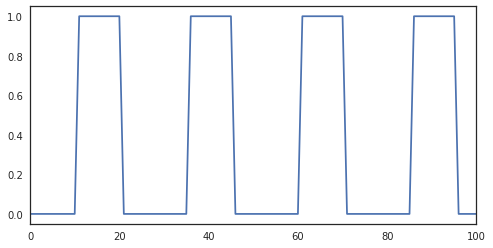

In [36]:
T = np.arange(0,500,1)
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%25>10 and t%25<21:
        tasktiming[0,t] = 1.0
plt.plot(T, tasktiming[0])
#plt.ylim(top = 1.2, bottom = -0.1)
plt.xlim(0,100)

In [2]:
def make_y(x, phi, rho, mu=0, sigma=1):
    y = y = np.zeros(len(x))
    
    noise = np.random.normal(mu, sigma, len(y))
    
    for i in range(len(y)):
        if i == 0:
            y[i] = copy.copy(x[i])
        else:
            noise[i] = rho*noise[i-1]+noise[i]
            y[i] = phi*y[i-1]+(1-phi)*x[i]+noise[i]
            
    return(y)

In [ ]:
def whiten(y, p=1, q=0):
    
    try:
        mod1 = ARMA(y, order=(p,q))
        res1 = mod1.fit()
        out = {'y_pw': res1.resid,
              'ar': res1.params[1]}
    except:
        out = {'y_pw': np.nan,
              'ar': np.nan}
    return(out)
    

In [3]:
def get_phi_rho(phi_stim, rho_stim, x=None, y=None, Tmax = 500, mu_stim=0, sigma_stim=1, verbose = True, ar_correction = True):
    
    if x is None:
        T = np.arange(0,Tmax,1)
        tasktiming = np.zeros((1,len(T)))
        for t in range(len(T)):
            if t%25>10 and t%25<21:
                tasktiming[0,t] = 1.0
        x = copy.copy(tasktiming[0])
    
    if y is None:
        y = make_y(x, rho=rho_stim, phi = phi_stim)
    
    X = x.reshape(-1,1)
    ## Constant/GLM:
    #X = sm.add_constant(X)
    y_lag = np.r_[0, y[:-1]]
    y_lag = y_lag.reshape(-1,1)
    X = np.concatenate((X, y_lag), 1)

    #No intercept model
    mod = sm.OLS(y, X)
    res = mod.fit()
    est_phi = res.params[1]
    
    errors = res.resid

    errors_lag = np.r_[0, errors[:-1]]
    errors_X = errors_lag.reshape(-1,1)

    #No intercept model
    error_mod = sm.OLS(errors, errors_X)
    error_res = error_mod.fit()
    est_rho = error_res.params[0]
    
    if verbose:
        print("Actual phi = %s; estimated phi = %s"%(phi_stim,str(round(est_phi, 5))))
        print("Actual rho = %s; estimated rho = %s"%(rho_stim, str(round(est_rho, 5))))
    
    out = {"phi_stim": phi_stim,
          'rho_stim': rho_stim,
          'phi_est': est_phi,
          'rho_est': est_rho}
    
    if ar_correction:
        arc_X = copy.copy(y_lag)
        y_lag2 = np.r_[0, np.r_[0, y[:-1]][:-1]]
        y_lag2 = y_lag2.reshape(-1,1)
        arc_X = np.concatenate((arc_X, y_lag2), 1)
        arc_X = np.concatenate((arc_X, x.reshape(-1,1)), 1)
        x_lag = np.r_[0, x[:-1]]
        x_lag = x_lag.reshape(-1,1)
        arc_X = np.concatenate((arc_X, x_lag), 1)
    
        arc_mod = sm.OLS(y, arc_X)
        arc_res = arc_mod.fit()
        
        est_phi_arc = 1 - arc_res.params[2]
        
        out.update({"phi_est_arc": est_phi_arc})
        
        if verbose:
            print("Actual phi = %s; estimated phi = %s"%(phi_stim,str(round(est_phi_arc, 5))))
    
    return(out, y)

In [ ]:
get_phi_rho(0.5,0.5)

In [4]:
def sim_rec_ac(phi_stim, rho_stim, x = None, y = None, mu_stim=0, sigma_stim=1, verbose = False, prewhiten = False, ar_correction=True):
        
    all_out = get_phi_rho(phi_stim=phi_stim, rho_stim=rho_stim, x=x, y=y, mu_stim=mu_stim, sigma_stim=sigma_stim, verbose = verbose, ar_correction=ar_correction)
    
    out = all_out[0]
    
    y = all_out[1]
    
    if prewhiten:
        if verbose:
            print("Prewhitening...")
            
        try:
            white_out = whiten(y)
            y_pw = white_out['y_pw']
            out.update({'ar': white_out['ar']})
            avec_pw = get_phi_rho(x=x, y=y_pw, phi_stim=phi_stim, rho_stim=rho_stim, mu_stim=mu_stim, sigma_stim=sigma_stim, verbose = verbose, ar_correction=False)[0]
            pw_adds = {'phi_est_pw': avec_pw['phi_est'],
                      'rho_est_pw': avec_pw['rho_est']}
        except:
            pw_adds = {'phi_est_pw': np.nan,
                       'rho_est_pw': np.nan}
        
        out.update(pw_adds)
    
    return(out)

Create predicted versus actual gradient/heat map

For 
10 values of phi  
10 values of rho  
plot absolute diff between predicted and actual parameter estimate  
separately for sans prewhitening and with prewhitening  

In [5]:
phi_stims=np.arange(0,1.1,.1)
rho_stims=np.arange(0,1.1,.1)

out = {}

for p in phi_stims:
    for r in rho_stims:
        sim_id = "phi_%s_rho_%s"%(p, r)
        out[sim_id] = sim_rec_ac(p, r)

In [7]:
out_df = pd.DataFrame(out).T

In [8]:
out_df.reset_index(drop=True,inplace=True)

In [9]:
out_df['phi_stim'] = round(out_df['phi_stim'],1)
out_df['rho_stim'] = round(out_df['rho_stim'],1)

out_df['phi_pct_diff'] = abs(out_df['phi_est'] - out_df['phi_stim'])/(out_df['phi_stim']+0.0000000000000001)
out_df['phi_pct_diff_arc'] = abs(out_df['phi_est_arc'] - out_df['phi_stim'])/(out_df['phi_stim']+0.0000000000000001)


/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


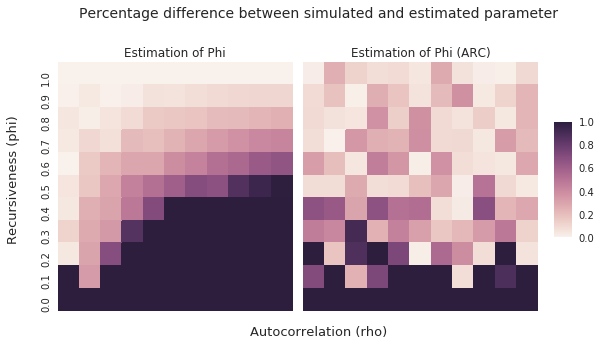

In [10]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 4
fig, axn = plt.subplots(1, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
vals = ['phi_pct_diff','phi_pct_diff_arc']
ax_titles = ['Estimation of Phi', 'Estimation of Phi (ARC)']
for i, ax in enumerate(axn.flat):
    df = out_df.pivot(index='phi_stim',columns='rho_stim',values='%s'%(vals[i]))
    sns.heatmap(df, ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                xticklabels=False, yticklabels=True,
                cbar_ax=None if i else cbar_ax)
    ax.set_title('%s'%(ax_titles[i]))
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.invert_yaxis()

fig.suptitle("Percentage difference between simulated and estimated parameter", fontsize=14, y = 1.1)
fig.text(-0.04, 0.5, 'Recursiveness (phi)', va='center', rotation='vertical', size=13)
fig.text(0.5, -0.04, 'Autocorrelation (rho)', ha='center', size = 13)
fig.tight_layout(rect=[0, 0, .9, 1])


In [31]:
def make_correlogram(y, max_lag):
    for i in range(2,max_lag):
        #y_lag = np.roll(y, -i)
        y_lag = np.roll(y, i)
        #y_lag = y_lag[:-i]
        y_lag[:i] = 0
        y_cur = y[:len(y_lag)]
        ac = (np.cov(y_cur, y_lag)[0][1]) / (np.var(y_cur))
        print("s = %s, AC = %s"%(str(i), str(ac)))

In [40]:
x = copy.copy(tasktiming[0])
y = make_y(x, 1, 0)
make_correlogram(y, 10)

s = 2, AC = 0.9702397034278211
s = 3, AC = 0.952511099247532
s = 4, AC = 0.9354360978844465
s = 5, AC = 0.9178131210923319
s = 6, AC = 0.898870406337761
s = 7, AC = 0.8800593585144488
s = 8, AC = 0.8593642799611753
s = 9, AC = 0.8377472033135286


In [41]:
y = make_y(x, .1, 0.5)
make_correlogram(y, 10)

s = 2, AC = 0.2758945430587769
s = 3, AC = 0.12113914242392318
s = 4, AC = 0.09775485832093248
s = 5, AC = 0.08209861562021274
s = 6, AC = 0.02230529417696815
s = 7, AC = 0.009330226150367328
s = 8, AC = -0.027083704767734515
s = 9, AC = -0.023345447192153933
